In [34]:
import yaml
import numpy as np

In [2]:
config = "../config/ptype.yml"

In [3]:
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [4]:
conf

{'seed': 1000,
 'verbose': 0,
 'save_loc': '/glade/work/schreck/repos/ptype/may23/results',
 'asos_path': '/glade/p/cisl/aiml/ai2es/winter_ptypes/precip_rap/ASOS_mixture/',
 'mping_path': '/glade/p/cisl/aiml/ai2es/winter_ptypes/precip_rap/mPING_mixture/',
 'data_path': '/glade/p/cisl/aiml/ai2es/winter_ptypes/ptype_qc/mPING_interpolated_QC2.parquet',
 'train_size1': 0.9,
 'train_size2': 0.0,
 'qc': 3.0,
 'test_cutoff': '2020-07-01',
 'ptypes': ['ra_percent', 'sn_percent', 'pl_percent', 'fzra_percent'],
 'metric': 'val_ave_acc',
 'direction': 'max',
 'ensemble': {'n_splits': 1, 'mc_steps': 0},
 'model': {'hidden_layers': 11,
  'hidden_neurons': 541,
  'use_dropout': 1,
  'dropout_alpha': 0.217191294429198,
  'batch_size': 1289,
  'lr': 0.0008707816746166255,
  'activation': 'elu',
  'output_activation': 'linear',
  'optimizer': 'adam',
  'loss': 'dirichlet',
  'annealing_coeff': 50,
  'loss_weights': [92.96912671890074,
   41.743749696615055,
   12.99938921008767,
   5.018459330108088],


In [5]:
input_features = conf['TEMP_C'] + conf['T_DEWPOINT_C'] + conf['UGRD_m/s'] + conf['VGRD_m/s']
output_features = conf['ptypes']

In [6]:
output_features

['ra_percent', 'sn_percent', 'pl_percent', 'fzra_percent']

### Load data

In [12]:
from ptype.data import load_ptype_uq, preprocess_data

In [9]:
data = load_ptype_uq(conf, data_split=0, verbose=1)

In [10]:
data.keys()

dict_keys(['train', 'val', 'test'])

In [11]:
data["train"].head()

,T_DEWPOINT_C_0_m,T_DEWPOINT_C_250_m,T_DEWPOINT_C_500_m,T_DEWPOINT_C_750_m,T_DEWPOINT_C_1000_m,T_DEWPOINT_C_1250_m,T_DEWPOINT_C_1500_m,T_DEWPOINT_C_1750_m,T_DEWPOINT_C_2000_m,T_DEWPOINT_C_2250_m,...,wetbulb5.0_filter,wetbulb3.0_filter,wetbulb4.0_filter,wetbulb6.0_filter,wetbulb7.0_filter,wetbulb8.0_filter,wetbulb9.0_filter,wetbulb10.0_filter,day,id
0,-1.655792,-2.835467,-4.163699,-6.138978,-0.488864,4.197807,5.157393,6.114103,6.829093,6.675503,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-01,0
1,-10.780792,-13.113944,-14.351792,-15.245550,-17.420716,-18.153632,-19.590563,-22.192989,-25.444098,-26.653295,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-01,1
2,-2.030670,-1.788266,-3.183992,-4.640100,-5.945332,-7.157136,-9.012771,-11.112327,-12.574477,-13.695213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-01,2
3,2.594330,2.729686,1.102943,-0.012984,-0.898779,-1.810851,-2.654946,-3.688597,-5.361815,-7.732323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-01,3
4,2.281830,3.372600,1.754350,0.367760,-0.655007,-1.669536,-2.636912,-3.866507,-5.746655,-8.543235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-01,4


In [13]:
scaled_data, scalers = preprocess_data(
        data,
        input_features,
        output_features,
        scaler_type="standard",
        encoder_type="onehot",
        groups=[],
    )

/glade/work/schreck/miniconda3/envs/evidential/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


##### Each input column gets transformed into "z-scores"

In [16]:
scaled_data["train_x"].head()

,TEMP_C_0_m,TEMP_C_250_m,TEMP_C_500_m,TEMP_C_750_m,TEMP_C_1000_m,TEMP_C_1250_m,TEMP_C_1500_m,TEMP_C_1750_m,TEMP_C_2000_m,TEMP_C_2250_m,...,VGRD_m/s_2750_m,VGRD_m/s_3000_m,VGRD_m/s_3250_m,VGRD_m/s_3500_m,VGRD_m/s_3750_m,VGRD_m/s_4000_m,VGRD_m/s_4250_m,VGRD_m/s_4500_m,VGRD_m/s_4750_m,VGRD_m/s_5000_m
0,-0.610768,-0.645662,-0.753968,-0.582651,-0.258674,-0.092146,0.050314,0.260894,0.472282,0.603402,...,0.870662,0.545611,0.331951,0.257136,0.232856,0.212132,0.177195,0.136428,0.096277,0.063459
1,-1.544597,-1.597331,-1.707733,-1.896648,-2.124362,-2.190931,-2.248633,-2.259476,-2.219144,-2.151906,...,-1.266968,-1.265000,-1.290175,-1.337132,-1.415796,-1.526929,-1.708339,-1.940517,-2.196968,-2.420509
2,-0.827267,-0.756607,-0.826003,-0.931763,-1.065001,-1.215805,-1.357762,-1.434078,-1.474066,-1.492524,...,-1.548890,-1.557793,-1.524601,-1.453846,-1.379509,-1.342068,-1.353519,-1.399035,-1.465413,-1.534068
3,-0.549342,-0.541780,-0.602278,-0.666170,-0.703255,-0.736447,-0.753797,-0.779801,-0.851306,-0.922395,...,1.737469,1.822353,1.906544,1.976829,2.011894,2.002315,1.971815,1.916722,1.831138,1.738343
4,-0.560459,-0.471010,-0.544565,-0.624629,-0.679935,-0.722399,-0.751941,-0.798688,-0.869158,-0.914975,...,1.717591,1.810358,1.896818,1.965159,1.999938,1.990657,1.947149,1.883099,1.806344,1.712216


##### The precip types are turned into "one-hots"

In [20]:
scaled_data["train_y"]

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

### Load a model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

2023-05-25 12:29:03.204844: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 12:29:03.467238: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-25 12:29:05.540233: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glade/u/apps/dav/opt/cuda/11.4.0/extras/CUPTI/lib64:/glade/u/apps/dav/opt/cuda/11.4.0/

In [23]:
# Create a Sequential model
model = Sequential()

# Add input layer and first hidden layer
model.add(Dense(units=100, activation='relu', input_shape=(len(input_features),)))

# Add second hidden layer
model.add(Dense(units=100, activation='relu'))

# Add output layer
model.add(Dense(units=len(output_features), activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print a summary of the model
model.summary()

2023-05-25 12:29:57.674087: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glade/u/apps/dav/opt/cuda/11.4.0/extras/CUPTI/lib64:/glade/u/apps/dav/opt/cuda/11.4.0/lib64:/glade/u/apps/dav/opt/openmpi/4.1.1/intel/19.1.1/lib:/glade/u/apps/dav/opt/ucx/1.11.0/lib:/glade/u/apps/opt/intel/2020u1/compilers_and_libraries/linux/lib/intel64:/glade/work/schreck/miniconda3/envs/evidential/lib/:/glade/work/schreck/miniconda3/envs/evidential/lib/python3.10/site-packages/nvidia/cudnn/lib
2023-05-25 12:29:57.674125: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for you

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               8500      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 4)                 404       
                                                                 
Total params: 19,004
Trainable params: 19,004
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [26]:
history = model.fit(
    scaled_data["train_x"], 
    scaled_data["train_y"], 
    validation_data = (scaled_data["val_x"], scaled_data["val_y"]),
    epochs = 10
)

Epoch 1/10
23189/23189 [==============================] - 26s 1ms/step - loss: 0.1018 - accuracy: 0.9134 - val_loss: 0.0993 - val_accuracy: 0.9148
Epoch 2/10
23189/23189 [==============================] - 26s 1ms/step - loss: 0.1002 - accuracy: 0.9147 - val_loss: 0.1000 - val_accuracy: 0.9144
Epoch 3/10
23189/23189 [==============================] - 26s 1ms/step - loss: 0.0993 - accuracy: 0.9154 - val_loss: 0.0985 - val_accuracy: 0.9163
Epoch 4/10
23189/23189 [==============================] - 26s 1ms/step - loss: 0.0987 - accuracy: 0.9160 - val_loss: 0.0978 - val_accuracy: 0.9165
Epoch 5/10
23189/23189 [==============================] - 27s 1ms/step - loss: 0.0982 - accuracy: 0.9166 - val_loss: 0.0990 - val_accuracy: 0.9155
Epoch 6/10
23189/23189 [==============================] - 27s 1ms/step - loss: 0.0977 - accuracy: 0.9171 - val_loss: 0.0996 - val_accuracy: 0.9158
Epoch 7/10
23189/23189 [==============================] - 26s 1ms/step - loss: 0.0974 - accuracy: 0.9171 - val_loss: 0

### Predict with the model

In [27]:
y_test_pred = model.predict(scaled_data["test_x"])

12397/12397 [==============================] - 8s 624us/step


In [35]:
for name in data.keys():
    x = scaled_data[f"{name}_x"]
    pred_probs = model.predict(x)
    true_labels = np.argmax(data[name][output_features].to_numpy(), 1)
    pred_labels = np.argmax(pred_probs, 1)
    confidences = np.take_along_axis(pred_probs, pred_labels[:, None], axis=1)
    data[name]["true_label"] = true_labels
    data[name]["pred_label"] = pred_labels
    data[name]["pred_conf"] = confidences
    for k in range(pred_probs.shape[-1]):
        data[name][f"pred_conf{k+1}"] = pred_probs[:, k]

12397/12397 [==============================] - 8s 611us/step


In [30]:
from ptype.plotting import plot_confusion_matrix

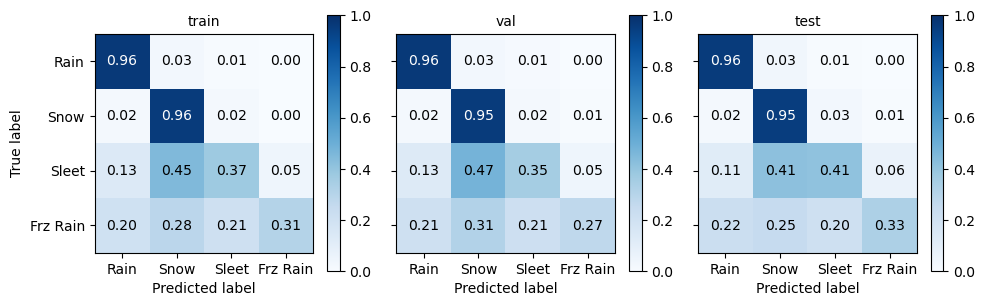

In [36]:
plot_confusion_matrix(
        data,
        ["Rain", "Snow", "Sleet", "Frz Rain"],
        normalize=True,
        #save_location=os.path.join(save_loc, "plots", "confusion_matrices.pdf"),
    )

In [38]:
from ptype.reliability import compute_calibration, reliability_diagrams
from collections import OrderedDict

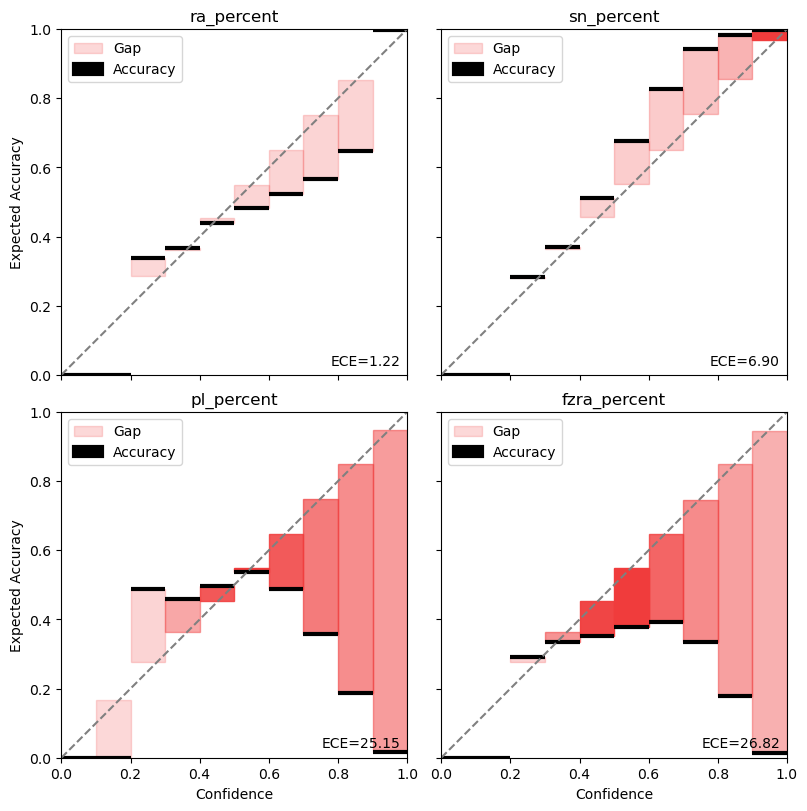

In [40]:
results = OrderedDict()
for label in range(len(output_features)):
    cond = data[name]["true_label"] == label
    results[output_features[label]] = {
        "true_labels": data[name][cond]["true_label"].values,
        "pred_labels": data[name][cond]["pred_label"].values,
        "confidences": data[name][cond]["pred_conf"].values,
    }
    results_calibration = compute_calibration(
        results[output_features[label]]["true_labels"],
        results[output_features[label]]["pred_labels"],
        results[output_features[label]]["confidences"],
        num_bins=10,
    )

_ = reliability_diagrams(
    results,
    num_bins=10,
    draw_bin_importance="alpha",
    num_cols=2,
    dpi=100,
    return_fig=True,
)